In [1]:
%load_ext autoreload
%autoreload 2

This notebook computes the infinite-width GP kernel for a GRU.
The code runs as is, and we summarize the derivation of the kernel in markdown cells, but the reader should take a look at the derivation in the paper to get the full picture.
We recommend the reader to have gone through [the RNN notebook](RNN.ipynb) first.

$\newcommand{\Gaus}{\mathcal{N}}$

Software Prerequisite

- R
- `rpy2` python package
- pandas

In [2]:
import rpy2
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector as FV
from numpy import asarray as npa
import numbers
import pandas as pd
import seaborn as sns
sns.set()
mvtnorm = importr('mvtnorm')
from rpy2.robjects import numpy2ri
numpy2ri.activate()
import matplotlib.pyplot as plt

In [3]:
from GRUtheory import *
from GRUsim import *

In [4]:
npa = np.asarray
randn = np.random.randn

Load the GloVe vectors and their covariances that we have saved.
They were generated from the two sentences

```The brown fox jumps over the dog.```

```The quick brown fox jumps over the lazy dog.```

Concretely, `exampleGloveVecs[:7]` contains the GloVe embeddings of the first sentence, and `exampleGloveVecs[7:16]` contains those of the second sentence.

Likewise, `exampleGloveCov` is a 16x16 matrix, such that `exampleGloveCov[:7, :7]` gives the autocovariance of the GloVe embeddings of the first sentence, `exampleGloveCov[7:, 7:]` gives that of the second sentence, and `exampleGloveCov[:7, 7:]` gives the covariance between those of the first and those of the second sentence.

In [5]:
sent1 = "The brown fox jumps over the dog".split()
sent2 = "The quick brown fox jumps over the lazy dog".split()

In [6]:
with open('ExampleGloVeVecs.npy', 'rb') as f:
    exampleGloveVecs = np.load(f)
with open('ExampleGloVeCov.npy', 'rb') as f:
    exampleGloveCov = np.load(f)

# GRU

The GRU we will study evolves according to the equations
\begin{align*}
    \tilde z^t &= W^z x^t + U^z h^{t-1} + b^z\\
    z^t &= sigmoid(\tilde z^t)\\
    \tilde r^t &= W^r x^t + U^r h^{t-1} + b^r\\
    r^t &= sigmoid(\tilde r^t)\\
    \tilde h^t &= W^h x^t + U^h(h^{t-1} \odot r^t) + b^h\\
    h^t &= (1 - z^t) \odot h^{t-1} + z^t \odot nonlin(\tilde h^t)
\end{align*}

where
    
- $h^t$ is state at time $t$
- $nonlin(\tilde h^t)$ is the "proposed update" at time $t$
- $x^t$ is input at time $t$
- $z^t \in [0, 1]$ is "update gate":
    - 1 means do update/forget previous $h^{t-1}$
    - 0 means $h^t = h^{t-1}$
- $r^t \in [0, 1]$ is "reset gate":
    - the smaller, the easier to make proposed update not depend on $h^{t-1}$
- $W^z, W^r, W^h$ are weights converting input to hidden states
- $U^z, U^r, U^h$ are weights converting state to state
- $b^z, b^r, b^h$ are biases    
- $nonlin(x) = erf(x)$
- $sigmoid(x) = (1 + erf(x)) / 2$
        

# NETSOR Representation of GRU Computation

The following gives the NETSOR representation of a GRU computation over a single sequence $x^1, \ldots, x^t$.

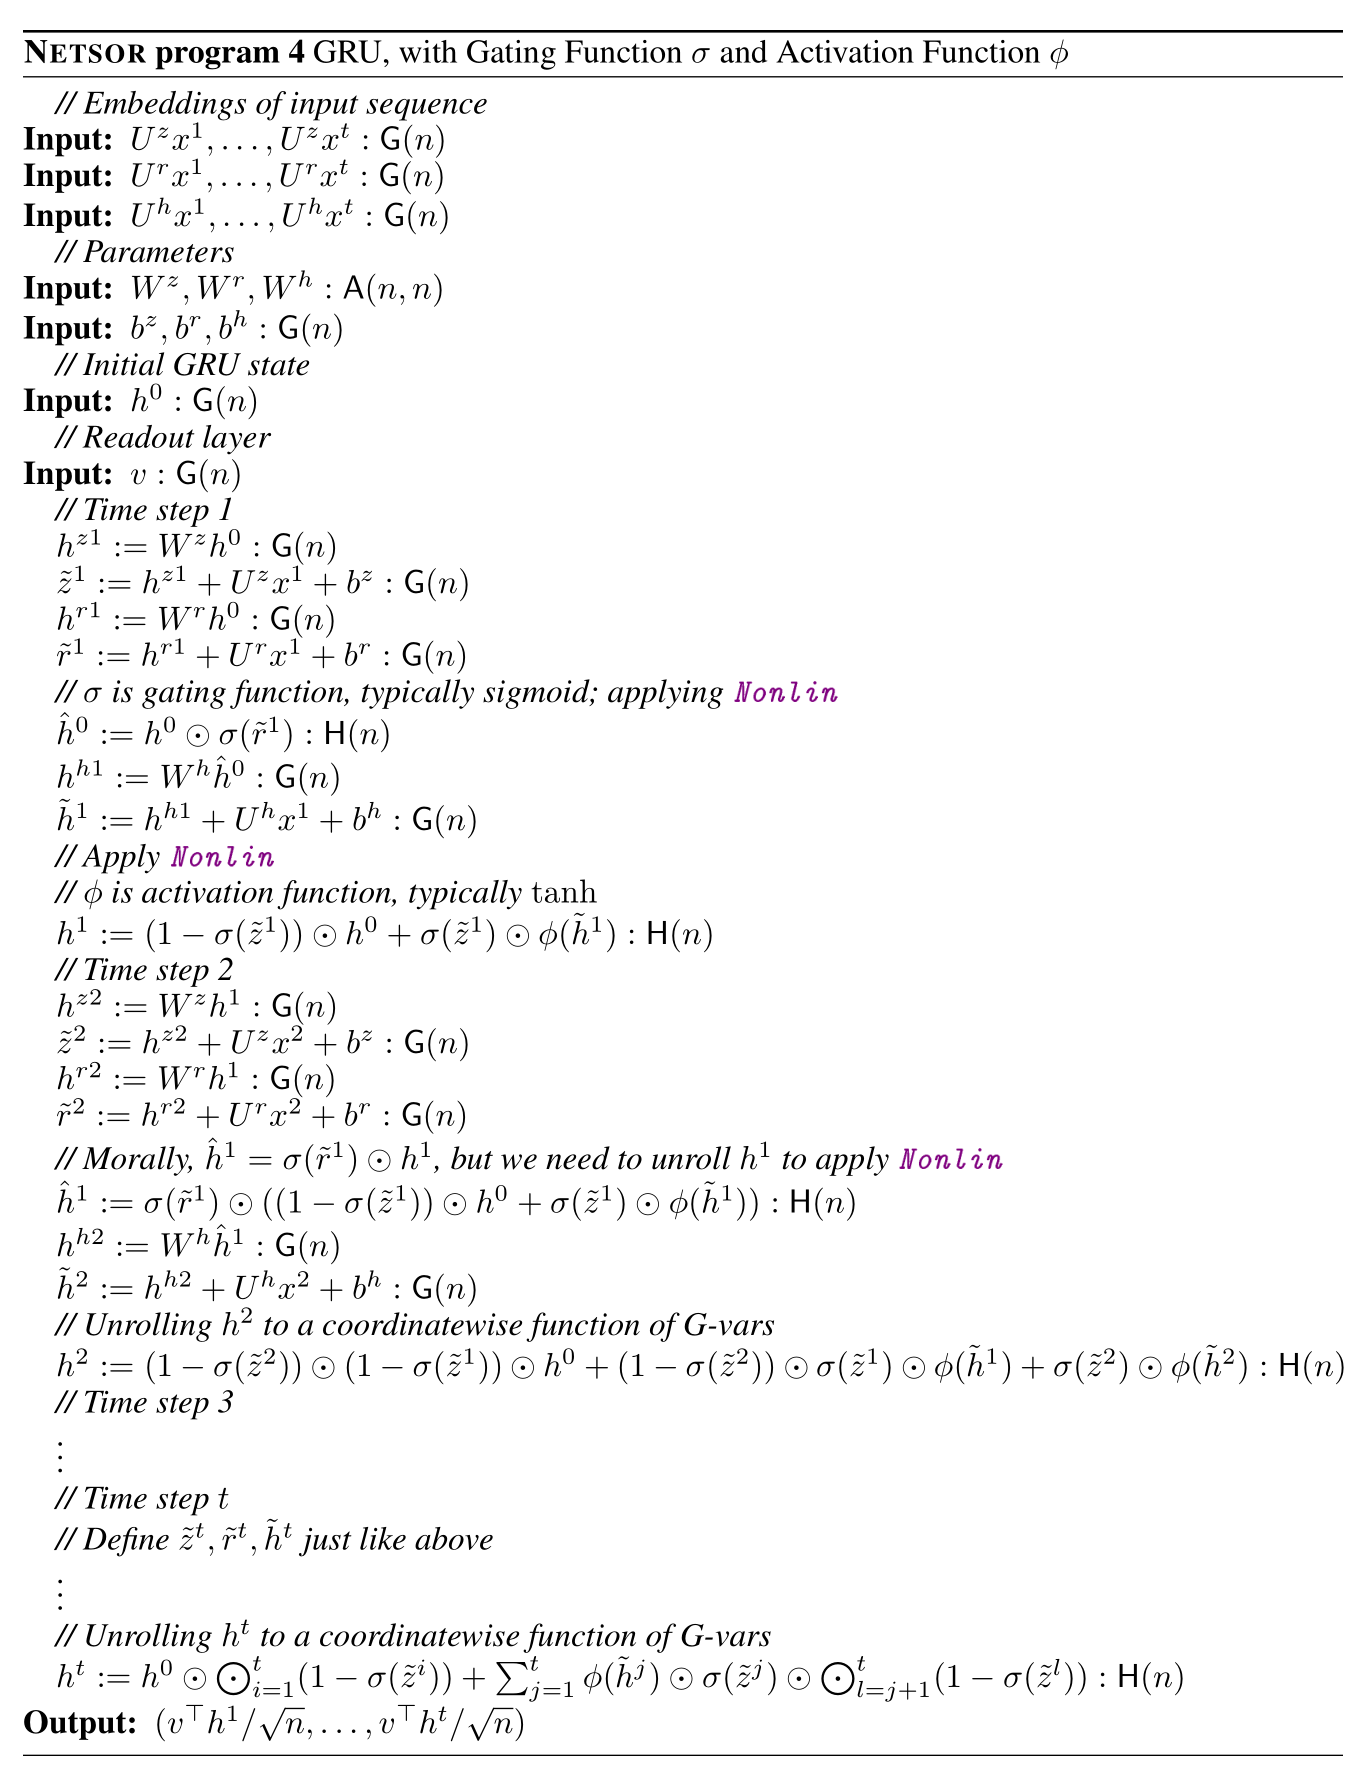

$\newcommand{\Gaus}{\mathcal{N}}$

Suppose we sample the parameters of the GRU as follows

- $U^z_{\alpha \beta}, U^r_{\alpha \beta}, U^h_{\alpha \beta} \sim \Gaus(0, \sigma_U^2/n)$
- $W^z_{\alpha\beta}, W^r_{\alpha\beta}, W^h_{\alpha\beta} \sim \Gaus(0, \sigma_W^2/n)$
- $b^z_\alpha, b^r_\alpha, b^h_\alpha \sim \Gaus(0, \sigma_b^2), v_\alpha \sim \Gaus(0, \sigma_v^2)$
- the initial state $h^0 = 0$.

The NETSOR Master Theorem tells us that, roughly speaking, all G-vars have coordinate slices that are jointly Gaussian, in the large $n$ limit, i.e. $\{g_\alpha: \text{$g$ is G-var}\}$ can be intuitively thought of as being distributed as $N(\tilde \mu, \tilde \Sigma)$ for some mean $\tilde \mu$ and kernel $\tilde \Sigma$

$\newcommand{\EV}{\operatorname*{\mathbb{E}}}$
Applying the NETSOR Master Theorem yields, for any two times $t, s$,
\begin{align*}
\tilde \Sigma(\tilde z^t, \tilde z^s)
    &=
        \tilde\Sigma(h^{zt}, h^{zs}) + \sigma_{U}^2 \langle x^t, x^s \rangle/m + \sigma_b^2
        \\
\tilde \Sigma(\tilde r^t, \tilde r^s)
    &=
        \tilde \Sigma(h^{rt}, h^{rs}) + \sigma_U^2 \langle x^t, x^s \rangle/m + \sigma_b^2
        \\
\tilde \Sigma(\tilde h^t, \tilde h^s)
    &=
        \tilde \Sigma(h^{ht}, h^{hs}) + \sigma_U^2 \langle x^t, x^s \rangle/m + \sigma_b^2
        \\
\tilde \Sigma(h^{zt}, h^{zs})
    &= \tilde \Sigma(h^{rt}, h^{rs})\\
    &=
        \sigma_W^2 \sum_{i=1}^t \sum_{j=1}^s \bigg\{
        \EV \phi(Z^{\tilde h^i})\phi(Z^{\tilde h^j})
        \\
    &\phantom{{}={}}\quad
        \times 
            \EV 
            \left[\sigma(Z^{\tilde z^i}) \prod_{\bar i = i+1}^t (1 - \sigma(Z^{\tilde z^{\bar i}}))\right]
            \times \left[
            \sigma(Z^{\tilde z^j}) \prod_{\bar j = j+1}^t (1 - \sigma(Z^{\tilde z^{\bar j}}))\right]
            \bigg\}
            \\
\tilde \Sigma(h^{ht}, h^{hs})
    &=
        \sigma_W^2 \tilde \Sigma(h^{zt}, h^{zs}) \EV \sigma(Z^{\tilde r^t})\sigma(Z^{\tilde r^s})
\end{align*}
where expectations are taken over $Z \sim \Gaus(\tilde \mu, \tilde \Sigma)$, which has one component for each G-var in the program.

$\newcommand{\erf}{\mathrm{erf}}$
If we replace $\phi$ with $\erf$ and $\sigma$ with $(1 + \erf)/2$, then
\begin{align*}
\EV \erf(Z^{\tilde h^i}) \erf(Z^{\tilde h^j}) = \frac 2 \pi \arcsin \frac{2\tilde\Sigma(\tilde h^i, \tilde h^j)}
{\sqrt{(2\tilde\Sigma(\tilde h^i, \tilde h^i)+1)(2\tilde\Sigma(\tilde h^j, \tilde h^j)+1)}}
\end{align*}

and more generally,
$$\EV_{Z \sim \Gaus(\mu, \Sigma)} \prod_{i=1} \sigma(Z_i) =
\EV_{Z \sim \Gaus(\mu, \Sigma)} \prod_{i=1} \frac{1 + \erf(Z_i)}{2} = \EV_{X \sim \Gaus(\mu, \Sigma + \frac 1 2 I)} \mathbb{I}(\forall i, X_i \ge 0).$$
See the paper for a derivation of this fact.
The RHS is called *Gaussian orthant probability* and can be evaluated quickly via the `R` package `mvtnorm`.

Using this fact,
$$\EV\sigma(Z^{\tilde r^t}) \sigma(Z^{\tilde r^s})
= \EV_{X \sim \Gaus(\tilde \mu|_{\tilde r^t, \tilde r^s}, \frac 1 2 I + \tilde \Sigma|_{\tilde r^t, \tilde r^s})}
    \mathbb{I}(X_1 \ge 0 \text{ and } X_2 \ge 0)$$
and 
\begin{align*}
    &\phantom{{}={}}\EV 
            \left[\sigma(Z^{\tilde z^i}) \prod_{\bar i = i+1}^t (1 - \sigma(Z^{\tilde z^{\bar i}}))\right]
            \times \left[
            \sigma(Z^{\tilde z^j}) \prod_{\bar j = j+1}^t (1 - \sigma(Z^{\tilde z^{\bar j}}))\right]
            \\
    &=
            \left[\sigma(Z^{\tilde z^i}) \prod_{\bar i = i+1}^t  \sigma(-Z^{\tilde z^{\bar i}})\right]
            \times \left[
            \sigma(Z^{\tilde z^j}) \prod_{\bar j = j+1}^t \sigma(-Z^{\tilde z^{\bar j}})\right]
            \\
    &=
    \EV_{X \sim \Gaus(\mu, \Sigma + \frac 1 2 I)} 
        \mathbb{I}(\forall i, X_i \ge 0)
\end{align*}
where $X$ has dimension $(t-i+1) + (s-j+1)$ and $\mu$ and $\Sigma$ are the mean and the covariances of the joint distribution of $(Z^{\tilde z^i}, -Z^{\tilde z^{i+1}}, \ldots, -Z^{\tilde z^{t}}, Z^{\tilde z^{j}}, -Z^{\tilde z^{j+1}}, -Z^{\tilde z^{s}})$ (so $\Sigma$ can possibly be singular as some of these variables are the same or negatives of each other).

The following functions implement different versions of the above expectation.

In [7]:
import rpy2
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector as FV
from rpy2.robjects import numpy2ri
numpy2ri.activate()
from numpy import asarray as npa
import numbers

mvtnorm = importr('mvtnorm')
r'''
We require the R package `mvtnorm` to compute certain high dimensional expectations
involving erfs, by reducing such expectations to Gaussian orthant probabilities
and evaluating them with `mvtnorm`.
'''
def Eerf2(mu, var):
    r'''
    Computes
        E[erf(x)^2: x ~ N(mu, var)]
    when mu and var are scalars, or
        E[erf(x) erf(y): (x, y) ~ N(mu, var)]
    when mu is a length-2 vector and var is a 2x2 matrix
    Example:
        >>> Eerf2([0, 0], [[1, 1], [1, 1]])
        0.4645590543975399
        
    Inputs:
        mu: scalar or length-2 vector
        var: scalar, or 2x2 matrix
    Outputs:
        Gaussian expectation as explained above
    '''
    scalar = False
    if isinstance(var, numbers.Number) or \
            isinstance(var, np.ndarray) and var.size == 1:
        mean = FV([mu, mu])
        var = np.array([var] * 4).reshape(2, 2) + 0.5 * np.eye(2)
        scalar = True
    else:
        mean = FV(mu)
        var = np.asarray(var + 0.5 * np.eye(2))
    ppprob = npa(mvtnorm.pmvnorm(lower=FV(np.zeros(2)), mean=mean, sigma=var))
    pnprob = npa(mvtnorm.pmvnorm(lower=FV(np.array([0, -np.inf])),
                           upper=FV(np.array([np.inf, 0])),
                           mean=mean, sigma=var))
    if scalar:
        npprob = pnprob
    else:
        npprob = npa(mvtnorm.pmvnorm(lower=FV(np.array([-np.inf, 0])),
                               upper=FV(np.array([0, np.inf])),
                               mean=mean, sigma=var))
    nnprob = npa(mvtnorm.pmvnorm(lower=FV(np.array([-np.inf, -np.inf])),
                           upper=FV(np.array([0, 0])),
                           mean=mean, sigma=var))
    return (ppprob + nnprob - pnprob - npprob)[0]
    
def Esigmoidprod(signs, mu, cov):
    r'''
    Computes
        E[prod_i sigmoid(sgn_i * x_i): (x_i)_i ~ N(mu, cov)]
    where
        sigmoid(x) = 0.5 (1 + erf(x))
        sgn_i = `signs`[i]
    Inputs:
        signs: a vector of +/-1
        mu: vector of means
        cov: matrix of covariances
    '''
    cov = npa(cov)
    signs = npa(signs)
    mu = npa(mu)
    cov = signs[:, None] * cov * signs[None, :] + 0.5 * np.eye(cov.shape[0])
    mu *= signs
    return npa(mvtnorm.pmvnorm(lower=FV(np.zeros_like(mu)),
                           mean=FV(mu),
                           sigma=cov))[0]
def Esigmoid2prod(signs1, signs2, mu, cov):
    r'''
    Computes
        E[(prod_i s_i s'_i): (x_i)_i ~ N(mu, cov)]
    where
        s_i = 1 if `signs1[i] == 0` or else sigmoid(`signs1[i]` * x_i)
        s'_i = 1 if `signs2[i] == 0` or else sigmoid(`signs2[i]` * x_i)
        sigmoid(x) = 0.5 (1 + erf(x))
        sgn_i = `signs`[i]
    Inputs:
        signs1: a vector with entries from {-1, 0, 1}
        signs2: a vector with entries from {-1, 0, 1}
    '''
    # the lazy way:
    # duplicate cov to reduce to the case with no repeat variables.
    signs1 = npa(signs1)
    signs2 = npa(signs2)
    mu = npa(mu)
    cov = npa(cov)
    n = cov.shape[0]
    newcov = np.zeros([2 * n , 2 * n])
    newcov[:n, :n] = newcov[:n, n:] = newcov[n:, :n] = newcov[n:, n:] = cov
    newmu = np.concatenate([mu, mu], axis=0)
    signs = np.concatenate([signs1, signs2], axis=0)
    zero_idx = set(np.argwhere(signs==0).reshape(-1))
    nonzero_idx = list(set(list(range(0, 2*n))) - zero_idx)
    signs = signs[nonzero_idx]
    newmu = newmu[nonzero_idx]
    newcov = newcov[nonzero_idx, :][:, nonzero_idx]
    return Esigmoidprod(signs, newmu, newcov)

A similar recursive formula exists for the G-vars computed over two distinct input sequences.

The functions `thgru` and `thgru2` below (also from `GRUtheory`) computes $\tilde \Sigma$ above respectively for one sequence and for two sequences.

In [8]:
def thgru(ingram, varUz=1, varUr=1, varUh=1,
          varWz=1, varWr=1, varWh=1,
          varbz=1, varbr=1, varbh=1,
          mubz=0, mubr=0, mubh=0):
    r'''
    Computes the infinite-width GP kernel of an erf-GRU over an input sequence
    with covariance `ingram`.
    An erf-GRU evolves according to the equations
    
        \tilde z^t = W_z x^t + U_z h^{t-1} + b_z
        z^t = sigmoid(\tilde z^t)
        \tilde r^t = W_r x^t + U_r h^{t-1} + b_r
        r^t = sigmoid(\tilde r^t)
        \tilde h^t = W_h x^t + U_h(h^{t-1} \odot r^t) + b_h
        h^t = (1 - z^t) \odot h^{t-1} + z^t \odot erf(\tilde h^t)
        
    where
    
        h^t is state at time t
        x^t is input at time t
        z^t is ``update gate``: 1 means do update/forget previous h^{t-1}
                                0 means h^t = h^{t-1}
        r^t is ``reset gate'':
            the smaller, the easier to make proposed update not depend on h^{t-1}
        W_z, W_r, W_h are weights converting input to hidden states
        U_z, U_r, U_h are weights converting state to state
        b_z, b_r, b_h are biases    
        sigmoid(x) = (1 + erf(x)) / 2
        
    We use erf-derived activations so that we can compute
    the infinite-width GP kernel tractably.
    Note that we assume the initial state h^0 is 0.

    Below `d` is the dimension of the hidden state.
    Inputs:
        ingram: gram matrix of input tokens (divided by their dimension)
        varUz: each element of U_z has variance `varUz`/d
        varUr: each element of U_r has variance `varUr`/d
        varUh: each element of U_h has variance `varUh`/d
        varWz: each element of W_z has variance `varWz`/d
        varWr: each element of W_r has variance `varWr`/d
        varWh: each element of W_h has variance `varWh`/d
        varbz: each element of b_z has variance `varbz`
        varbr: each element of b_r has variance `varbr`
        varbh: each element of b_h has variance `varbh`
        mubz: each element of b_z has mean `mubz`
        mubr: each element of b_r has mean `mubr`
        mubh: each element of b_h has mean `mubh`
    Outputs:
        a dictionary with the following keys, which are associated to functions
        which are lazily evaluated:
        
        covhtht: covhtht(t, s) = covariance(\tilde h^t, \tilde h^s)
        covztzt: covztzt(t, s) = covariance(\tilde z^t, \tilde z^s)
        covrtrt: covrtrt(t, s) = covariance(\tilde r^t, \tilde r^s)
        Ess: Ess(t, s) = E erf(\tilde h^t) erf(\tilde h^s)
        Ezwzw: Ezwzw(a, t, b, s) = E zweight(a, t) zweight(b, s)
                where zweight(a, t) = z^a (1 - z^(a + 1)) ... (1 - z^t)
        Ehh: Ehh(t, s) = E h^t h^s
        Err: Err(t, s) = E r^t r^s
        
        Here, for two vectors of dimension m, let
            
            covariance(u, v) = u^T v / m

        The returned dictionary also contains dictionaries which hold the memoized values
        of the above functions. Their keys are the same but prefixed with `_`:
        
        _covhtht
        _covztzt
        _covrtrt
        _Ess
        _Ezwzw
        _Ehh
        _Err
        
    '''
    # covhtht(t, s) = covariance(\tilde h^t, \tilde h^s)
    _covhtht = {}
    def covhtht(t, s):
        if (t, s) in _covhtht:
            return _covhtht[(t, s)]
        if t < s:
            return covhtht(s, t)
        # covhtht(1, 1) inolves the first token, ingram[0, 0]
        _covhtht[(t, s)] = varWh * ingram[t-1, s-1] + \
            varUh * Ehh(t-1, s-1) * Err(t, s) + varbh
        return _covhtht[(t, s)]
    # Ess(t, s) = E erf(\tilde h^t) erf(\tilde h^s)
    _Ess = {}
    def Ess(t, s):
        if (t, s) in _Ess:
            return _Ess[(t, s)]
        if t < s:
            return Ess(s, t)
        elif t == s:
            _Ess[(t, s)] = Eerf2(mubh, covhtht(t, t))
            return _Ess[(t, s)]
        else:
            cov = [[covhtht(t, t), covhtht(t, s)],
                  [covhtht(t, s), covhtht(s, s)]]
            _Ess[(t, s)] = Eerf2([mubh, mubh], cov)
            return _Ess[(t, s)]
    # Ezwzw(a, t, b, s) = E zweight(a, t) zweight(b, s)
    #     where zweight(a, t) = z^a (1 - z^(a + 1)) ... (1 - z^t)
    _Ezwzw = {}
    def Ezwzw(a, t, b, s):
        if (a, t, b, s) in _Ezwzw:
            return _Ezwzw[(a, t, b, s)]
        if t < s:
            return Ezwzw(b, s, a, t)
        min_ = min(a, b)
        max_ = max(t, s)
        def getidx(i):
            return i - min_
        cov = [[covztzt(i, j) for i in range(min_, max_+1)]
              for j in range(min_, max_+1)]
        signs1 = np.zeros([max_ - min_ + 1])
        signs1[getidx(a)] = 1
        signs1[getidx(a)+1:getidx(t)+1] = -1
        signs2 = np.zeros([max_ - min_ + 1])
        signs2[getidx(b)] = 1
        signs2[getidx(b)+1:getidx(s)+1] = -1
        _Ezwzw[(a, t, b, s)] = Esigmoid2prod(signs1, signs2,
                                 np.zeros([max_ - min_ + 1]) + mubz,
                                 cov)
        return _Ezwzw[(a, t, b, s)]
    # Ehh(t, s) = E h^t h^s
    _Ehh = {}
    def Ehh(t, s):
        if (t, s) in _Ehh:
            return _Ehh[(t, s)]
        if t == 0 or s == 0:
            return 0
        elif t < s:
            return Ehh(s, t)
        else:
            _Ehh[(t, s)] = sum([
                    Ezwzw(a, t, b, s) * Ess(a, b)
                    for a in range(1, t+1)
                    for b in range(1, s+1)
            ])
            return _Ehh[(t, s)]
    # covztzt(t, s) = covariance(\tilde z^t, \tilde z^s)
    _covztzt = {}
    def covztzt(t, s):
        if (t, s) in _covztzt:
            return _covztzt[(t, s)]
        if t < s:
            return covztzt(s, t)
        # covztzt(1, 1) inolves the first token, ingram[0, 0]
        _covztzt[(t, s)] = varWz * ingram[t-1, s-1] \
                + varUz * Ehh(t-1, s-1) + varbz
        return _covztzt[(t, s)]
    # covrtrt(t, s) = covariance(\tilde r^t, \tilde r^s)
    _covrtrt = {}
    def covrtrt(t, s):
        if (t, s) in _covrtrt:
            return _covrtrt[(t, s)]
        if t < s:
            return covrtrt(s, t)
        # covrtrt(1, 1) inolves the first token, ingram[0, 0]
        _covrtrt[(t, s)] = varWr * ingram[t-1, s-1] \
                + varUr * Ehh(t-1, s-1) + varbr
        return _covrtrt[(t, s)]
    # Err(t, s) = E r^t r^s
    _Err = {}
    def Err(t, s):
        if (t, s) in _Err:
            return _Err[(t, s)]
        if t < s:
            return Err(s, t)
        elif t == s:
            _Err[(t, s)] = Esigmoid2prod([1], [1], [mubr], [covrtrt(t, t)])
            return _Err[(t, s)]
        else:
            cov = [[covrtrt(i, j) for i in [t, s]]
                  for j in [t, s]]
            _Err[(t, s)] = Esigmoidprod([1, 1], [mubr, mubr], cov)
            return _Err[(t, s)]
    return dict(covhtht=covhtht, Ess=Ess, Ezwzw=Ezwzw,
               Ehh=Ehh, covztzt=covztzt, covrtrt=covrtrt,
               Err=Err,
               _covhtht=_covhtht, _Ess=_Ess, _Ezwzw=_Ezwzw,
               _Ehh=_Ehh, _covztzt=_covztzt, _covrtrt=_covrtrt,
               _Err=_Err)

def thgru2(in1covs, in2covs, ingramx, 
            varUz=1, varUr=1, varUh=1,
            varWz=1, varWr=1, varWh=1,
            varbz=1, varbr=1, varbh=1,
            mubz=0, mubr=0, mubh=0):
    r'''Same as `thgru` but over 2 sequences.

    For two vectors of dimension d, let
        
        covariance(u, v) = u^T v / d

    Inputs:
        `in1covs`: dict returned by `thgru` applied to 1st sequence
        `in2covs`: dict returned by `thgru` applied to 2nd sequence
        `ingramx`: the covariance btw the 1st and 2nd sequence
            ingramx[i, j] = covariance(seq1[i], seq2[j])

    Outputs:
        a dictionary with the following keys, which are associated to functions
        which are lazily evaluated:
        
        covhtht: covhtht(t, s) = covariance(\tilde h1^t, \tilde h2^s)
        covztzt: covztzt(t, s) = covariance(\tilde z1^t, \tilde z2^s)
        covrtrt: covrtrt(t, s) = covariance(\tilde r1^t, \tilde r2^s)
        Ess: Ess(t, s) = E erf(\tilde h1^t) erf(\tilde h2^s)
        Ezwzw: Ezwzw(a, t, b, s) = E zweight1(a, t) zweight2(b, s)
                where zweight1(a, t) = z1^a (1 - z1^(a + 1)) ... (1 - z1^t)
                and zweight2(a, t) = z2^a (1 - z2^(a + 1)) ... (1 - z2^t)
        Ehh: Ehh(t, s) = E h1^t h2^s
        Err: Err(t, s) = E r1^t r2^s

        Here ?1 and ?2 refer to the vectors obtained from the 1st or the 2nd sequence
        
        the dictionary also contains dictionaries which hold the memoized values
        of the above functions. Their keys are the same but prefixed with `_`:
        
        _covhtht
        _covztzt
        _covrtrt
        _Ess
        _Ezwzw
        _Ehh
        _Err

    '''
    # covhtht(t, s) = covariance(\tilde h1^t, \tilde h2^s)
    _covhtht = {}
    def covhtht(t, s):
        if (t, s) in _covhtht:
            return _covhtht[(t, s)]
        # covhtht(1, 1) inolves the first token, ingram[0, 0]
        _covhtht[(t, s)] = varWh * ingramx[t-1, s-1] + \
            varUh * Ehh(t-1, s-1) * Err(t, s) + varbh
        return _covhtht[(t, s)]
    # Ess(t, s) = E erf(\tilde h1^t) erf(\tilde h2^s)
    _Ess = {}
    def Ess(t, s):
        if (t, s) in _Ess:
            return _Ess[(t, s)]
        else:
            cov = [[in1covs['covhtht'](t, t), covhtht(t, s)],
                  [covhtht(t, s), in2covs['covhtht'](s, s)]]
            _Ess[(t, s)] = Eerf2([mubh, mubh], cov)
            return _Ess[(t, s)]
    # Ezwzw(a, t, b, s) = E zweight1(a, t) zweight2(b, s)
    #     where zweight1(a, t) = z1^a (1 - z1^(a + 1)) ... (1 - z1^t)
    #           zweight2(a, t) = z2^a (1 - z2^(a + 1)) ... (1 - z2^t)
    _Ezwzw = {}
    def Ezwzw(a, t, b, s):
        if (a, t, b, s) in _Ezwzw:
            return _Ezwzw[(a, t, b, s)]
        min_ = min(a, b)
        max_ = max(t, s)
        def getidx(i):
            return i - min_
        cov1 = npa([[in1covs['covztzt'](i, j) for i in range(a, t+1)]
                for j in range(a, t+1)])
        cov2 = npa([[in2covs['covztzt'](i, j) for i in range(b, s+1)]
                for j in range(b, s+1)])
        covx = npa([[covztzt(i, j) for j in range(b, s+1)]
              for i in range(a, t+1)])
        cov = np.block(
            [[cov1, covx],
             [covx.T, cov2]])
        signs1 = [1] + [-1] * (t - a)
        signs2 = [1] + [-1] * (s - b)
        _Ezwzw[(a, t, b, s)] = Esigmoidprod(signs1 + signs2,
                                 np.zeros([cov.shape[0]]) + mubz,
                                 cov)
        return _Ezwzw[(a, t, b, s)]
    # Ehh(t, s) = E h1^t h2^s
    _Ehh = {}
    def Ehh(t, s):
        if (t, s) in _Ehh:
            return _Ehh[(t, s)]
        if t == 0 or s == 0:
            return 0
        else:
            _Ehh[(t, s)] = sum([
                    Ezwzw(a, t, b, s) * Ess(a, b)
                    for a in range(1, t+1)
                    for b in range(1, s+1)
            ])
            return _Ehh[(t, s)]
    # covztzt(t, s) = covariance(\tilde z1^t, \tilde z2^s)
    _covztzt = {}
    def covztzt(t, s):
        if (t, s) in _covztzt:
            return _covztzt[(t, s)]
        # covztzt(1, 1) inolves the first token, ingram[0, 0]
        _covztzt[(t, s)] = varWz * ingramx[t-1, s-1] \
                + varUz * Ehh(t-1, s-1) + varbz
        return _covztzt[(t, s)]
    # covrtrt(t, s) = covariance(\tilde r1^t, \tilde r2^s)
    _covrtrt = {}
    def covrtrt(t, s):
        if (t, s) in _covrtrt:
            return _covrtrt[(t, s)]
        # covrtrt(1, 1) inolves the first token, ingram[0, 0]
        _covrtrt[(t, s)] = varWr * ingramx[t-1, s-1] \
                + varUr * Ehh(t-1, s-1) + varbr
        return _covrtrt[(t, s)]
    # Err(t, s) = E r1^t r2^s
    _Err = {}
    def Err(t, s):
        if (t, s) in _Err:
            return _Err[(t, s)]
        else:
            cov = [[in1covs['covrtrt'](t, t), covrtrt(t, s)],
                  [covrtrt(t, s), in2covs['covrtrt'](s, s)]]
            _Err[(t, s)] = Esigmoidprod([1, 1], [mubr, mubr], cov)
            return _Err[(t, s)]
    return dict(covhtht=covhtht, Ess=Ess, Ezwzw=Ezwzw,
               Ehh=Ehh, covztzt=covztzt, covrtrt=covrtrt,
               Err=Err,
               _covhtht=_covhtht, _Ess=_Ess, _Ezwzw=_Ezwzw,
               _Ehh=_Ehh, _covztzt=_covztzt, _covrtrt=_covrtrt,
               _Err=_Err)

# Theory: Infinite-Width Kernel of GRU Embeddings

We first compute the covariance between the output of an randomly initialized, infinite-width GRU that has been run on the two sentences.

`gruGloVe1` contains a collection of functions that each computes the covariance between quantities generated by the GRU over the course of running over the first sentence.
For example, `gruGloVe1['Ehh'](i, j)` is the normalized inner product between the GRU embedding of the first sentence up to $i$th word and first sentence up to $j$th word.
Its evaluation needs the values `gruGloVe1['Ehh'](ii, jj)` for $(ii, jj) \le (i, j), (ii, jj) \ne (i, j)$, which is cached after the being computed for the first time.
See documentation for other examples of functions contained in the output of `thgru`.

Likewise, `gruGloVex['Ehh']` gives the normalized inner product between the GRU embeddings of the first and the second sentence.

In [9]:
gruGloVe1 = thgru(exampleGloveCov[:7, :7])
gruGloVe2 = thgru(exampleGloveCov[7:, 7:])
gruGloVex = thgru2(gruGloVe1, gruGloVe2, exampleGloveCov[:7, 7:])

We store the normalized inner products in numpy arrays `ker1`, `ker2`, `kerx`.
`ker1` contains the autocovariance of the GRU embeddings of the first sentence; `ker2` contains those of the second sentence.
`kerx` contains the covariance of the GRU embeddings of the first and the second sentence.

The big matrix `ker` arranges `ker1`, `ker2`, `kerx` in block form.

Note: This cell may take up to a minute to run.

In [10]:
ker1 = npa([[gruGloVe1['Ehh'](i, j) for i in range(1, 8)]
           for j in range(1, 8)])
ker2 = npa([[gruGloVe2['Ehh'](i, j) for i in range(1, 10)]
           for j in range(1, 10)])
kerx = npa([[gruGloVex['Ehh'](i, j) for j in range(1, 10)]
           for i in range(1, 8)])
ker = np.block(
    [[ker1, kerx],
     [kerx.T, ker2]]
)

This is what `ker` looks like.
Note the block structure, which corresponds to the two sentences.

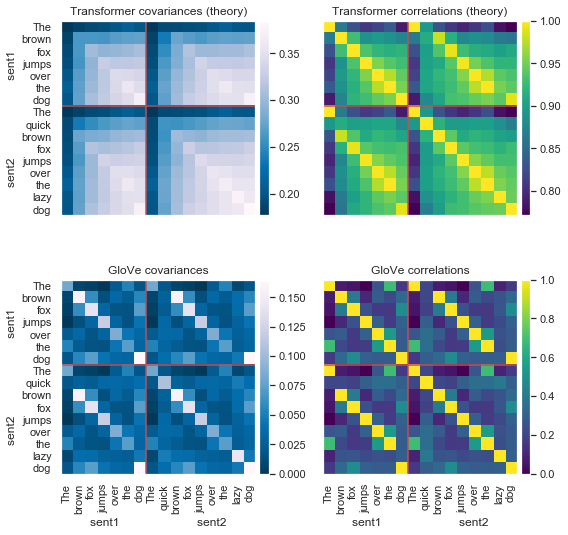

In [11]:
from utils import getCor, colorbar

plt.figure(figsize=(8, 8))

plt.subplot(221)
ax = plt.gca()
im_thcov = plt.imshow(ker, cmap='PuBu_r')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks(np.arange(16), sent1+sent2)
plt.xticks([])
plt.title('Transformer covariances (theory)')
plt.ylabel('sent2                       sent1')
plt.grid()
colorbar(im_thcov)

plt.subplot(222)
ax = plt.gca()
im_thcor = plt.imshow(getCor(ker), cmap='viridis')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks([])
plt.xticks([])
plt.title('Transformer correlations (theory)')
plt.grid()
colorbar(im_thcor)


plt.subplot(223)
ax = plt.gca()
im_glove = plt.imshow(exampleGloveCov, cmap='PuBu_r')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks(np.arange(16), sent1+sent2)
plt.xticks(np.arange(16), sent1+sent2, rotation=90)
plt.title('GloVe covariances')
plt.xlabel('sent1                       sent2')
plt.ylabel('sent2                       sent1')
plt.grid()
colorbar(im_glove)

plt.subplot(224)
ax = plt.gca()
im_glovecor = plt.imshow(getCor(exampleGloveCov), cmap='viridis')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks([])
plt.xticks(np.arange(16), sent1+sent2, rotation=90)
plt.title('GloVe correlations')
plt.xlabel('sent1                       sent2')
plt.grid()
colorbar(im_glovecor)

plt.tight_layout()

In [12]:
with open('GRU.kernel', 'wb') as f:
    np.save(f, ker)

# Simulation: Large (but Finite) Width Kernel of GRU Embeddings

We randomly initialize 100 GRUs for each width among $[2^5, 2^6, \ldots, 2^{13}]$ and run them on the two sentences above.
We calculate the empirical Gram matrix of the GRU embeddings as well as its Frobenius distance to the infinite-width theoretical kernel `ker`.

In [13]:
widths = [2**i for i in range(5, 13)]
frobs = []
for d_h in widths:
    for _ in range(100):
        glovesimx = simgru2(th.from_numpy(exampleGloveVecs[:7]),
                           th.from_numpy(exampleGloveVecs[7:]),
                           d_h,
                  nonlin=Erf, sigmoid=ErfSigmoid,
                 wt_tie=True, bias=True)
        diff = glovesimx['hcov'] - ker
        frobs.append({
            "absfrob": np.linalg.norm(diff)**2,
            "relfrob": (np.linalg.norm(diff) / np.linalg.norm(ker))**2,
            "width": d_h
        })

We store the results in a dataframe `frob_df`.

In [14]:
frob_df = pd.DataFrame(frobs)

In [15]:
frob_df.to_pickle('GRU.df')

The deviation from infinite-width theory drops with width, as expected.

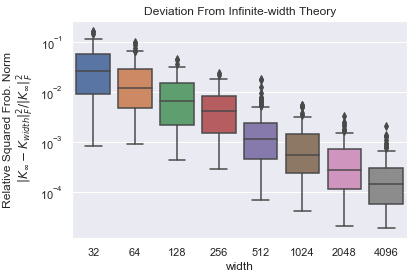

In [16]:
sns.boxplot(x='width', y='relfrob', data=frob_df)
plt.semilogy()
# plt.legend()
plt.title('Deviation From Infinite-width Theory')
_ = plt.ylabel(u'Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')

The deviation from theory in *squared* Frobenius norm scales like $\frac{1}{width}$ (so, in Frobenius norm, the deviation scales like $width^{-1/2}$).

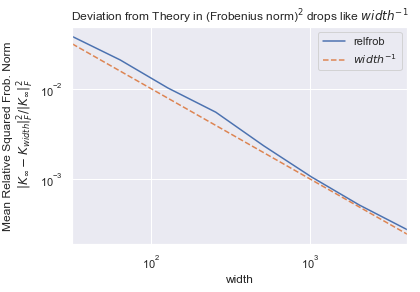

In [17]:
frob_df.groupby('width', as_index=False).mean().plot.line(x='width', y='relfrob')
plt.plot(widths, np.array(widths, dtype='float')**-1, '--', label=u'${width}^{-1}$')
plt.ylabel(u'Mean Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')
plt.loglog()
plt.legend()
_ = plt.title(u'Deviation from Theory in (Frobenius norm)$^2$ drops like $width^{-1}$')